# Speech Sample Analysis

This notebook goes through a simple analysis of a single speech sample

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from speechbrain.processing.voice_analysis import *

sns.set()

Text(0, 0.5, 'Amplitude')

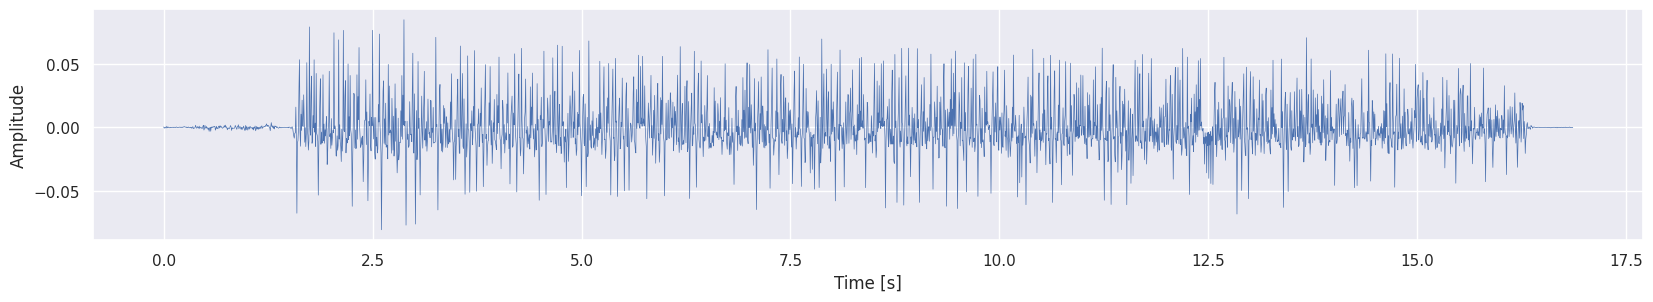

In [2]:
# Load audio and generate stats
audio, sample_rate = torchaudio.load("qpn_PD00020_a1.wav")

downsample_factor = 100
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

## Intro

To understand how this speech analysis works, we'll step through the `vocal_characteristics` function. The very fist lines
just set up the variables needed for computation

In [3]:
# Frequency of human speech is usually between 75-300 Hz
min_f0_Hz = 75
max_f0_Hz = 300

# A new window of 0.04 second length every 0.01 seconds
step_size = 0.01
window_size = 0.04

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag_samples = int(sample_rate / min_f0_Hz)
min_lag_samples = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag_samples)
print("Number of samples in the minimum lag:", min_lag_samples)

Samples between (the start of) one frame and the next: 160
Samples contained within each frame: 640
Number of samples in the maximum lag: 213
Number of samples in the minimum lag: 53


Our sanity check for these values is that at least 3 periods will be contained in the frame (for minimum Hz) and at most 12 for maximum Hz.

## Getting voiced portion

In order to do a f0 analysis, we have to figure out which portions are harmonic. We use both autocorrelation and power ratio.

The first relevant value is the ratio of the power of a lowpassed audio signal against the power of the original signal.
Power is not a 1:1 correspondance with loudness but they are correlated.

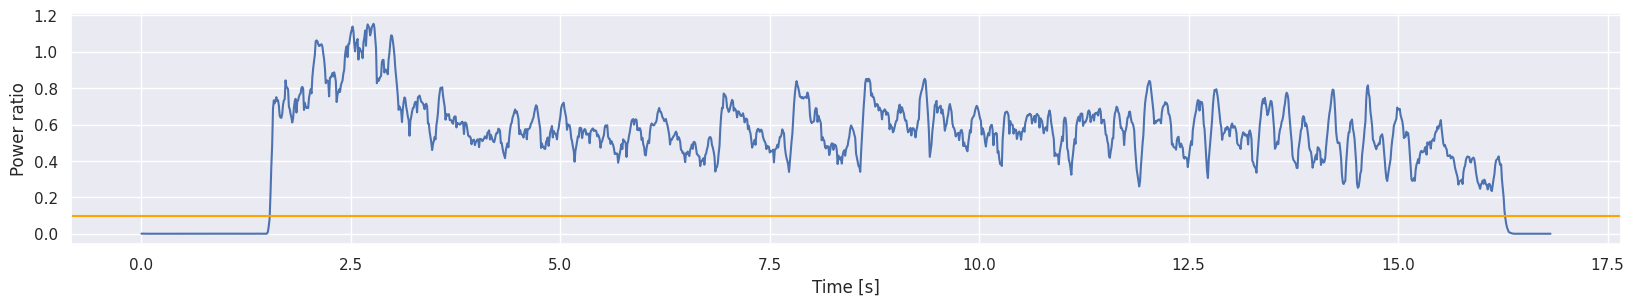

In [4]:
orig_windows = audio.unfold(-1, window_samples, step_samples)
lowpass_audio = torchaudio.functional.lowpass_biquad(audio, sample_rate, 800)
lowpass_windows = lowpass_audio.unfold(-1, window_samples, step_samples)
power_ratio = compute_power_ratio(orig_windows, lowpass_windows).squeeze()

power_threshold = 0.1
xs = torch.arange(len(power_ratio)) * step_size
plt.plot(xs, power_ratio)
plt.xlabel("Time [s]")
plt.ylabel("Power ratio")
plt.axhline(y = power_threshold, color="orange")

Autocorrelation is the cross-correlation of a signal with itself at various lags.
For harmonic signals, there are peaks at regular intervals corresponding to the period.
The autocorrelation ratio is the ratio of the strongest peak against the theoretical maximum
which occurs when the lag is zero.

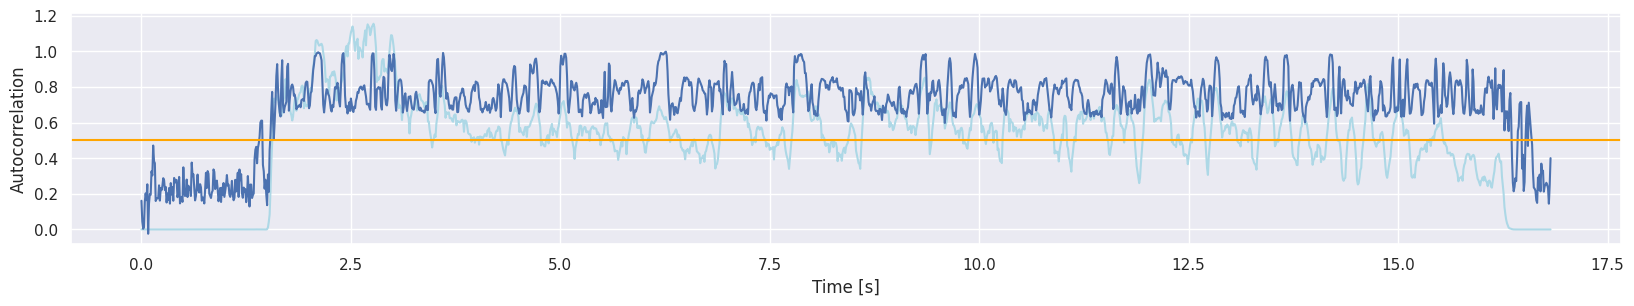

In [5]:
kbest_lags, autocorrelation_ratio = autocorrelate(
    lowpass_windows, min_lag_samples, max_lag_samples
)

autocorrelation_threshold = 0.5
plt.plot(xs, power_ratio, color="lightblue")
plt.plot(xs, autocorrelation_ratio)
plt.xlabel("Time [s]")
plt.ylabel("Autocorrelation")
plt.axhline(y = autocorrelation_threshold, color="orange")

Text(0, 0.5, 'Voiced Value')

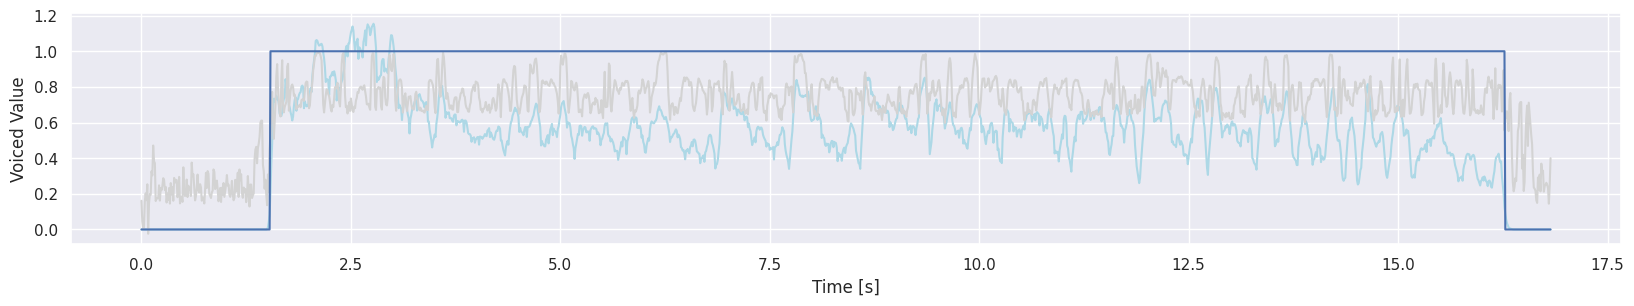

In [6]:
# voicing threshold is simply the intersection of these thresholds
voiced = autocorrelation_ratio > autocorrelation_threshold
voiced &= power_ratio > power_threshold

plt.plot(xs, power_ratio, color="lightblue")
plt.plot(xs, autocorrelation_ratio, color="lightgrey")
plt.plot(xs, voiced)
plt.xlabel("Time [s]")
plt.ylabel("Voiced Value")

In [7]:
print("Total frame count:", len(voiced))
print("Voiced frame count:", voiced.sum().numpy())

Total frame count: 1683
Voiced frame count: 1474


## Computing f0

The fundamental frequency, f0, is the period of the waveform. This is computed by taking the
k-best lags from the autocorrelation and comparing to neighboring frames to avoid octave errors.

Estimated average frequency: tensor(122.7575)


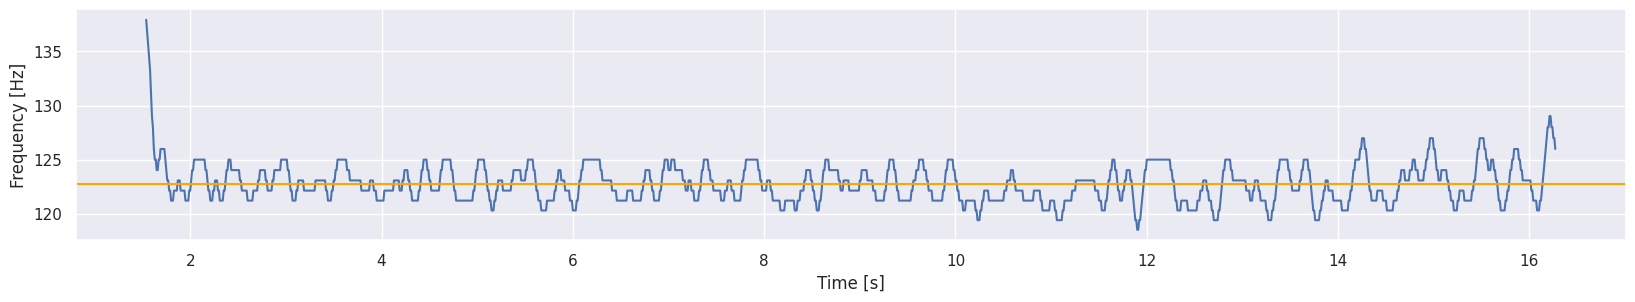

In [8]:
# Only compute f0 on voiced frames, it doesn't make sense on unvoiced ones.
best_lags = iterative_lag_selection(kbest_lags[voiced], iterations=3)

# Convert to hZ
estimated_f0 = sample_rate / best_lags

voiced_xs = xs[voiced]
plt.plot(voiced_xs, estimated_f0)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.axhline(y = estimated_f0.mean(), color="orange")
print("Estimated average frequency:", estimated_f0.mean())

## Computing vocal characteristics

Common vocal characteristics are jitter, shimmer, and harmonic-to-noise ratio

In [9]:
jitter, shimmer, hnr = compute_periodic_features(orig_windows[:, voiced], best_lags)

Average Jitter: 0.49%


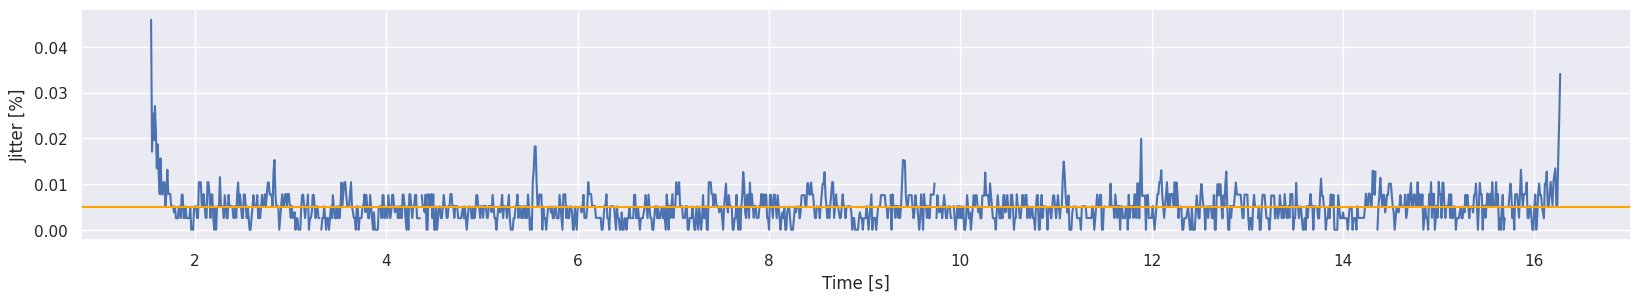

In [10]:
plt.plot(voiced_xs, jitter)
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = jitter.nanmean(), color="orange")
print("Average Jitter: {0:.2f}%".format(100 * jitter.nanmean().numpy()))

Average Shimmer: 3.50%


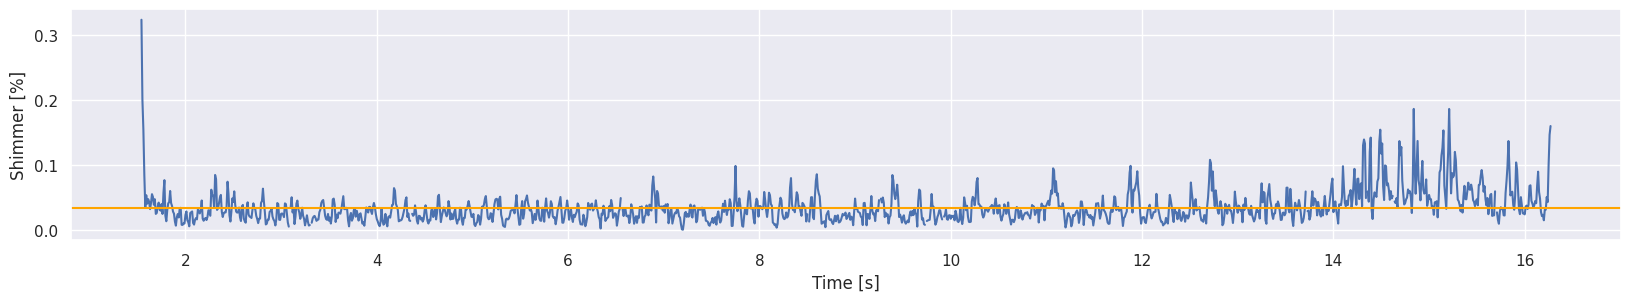

In [11]:
plt.plot(voiced_xs, shimmer)
plt.xlabel("Time [s]")
plt.ylabel("Shimmer [%]")
plt.axhline(y = shimmer.nanmean(), color="orange")
print("Average Shimmer: {0:.2f}%".format(100 * shimmer.nanmean().numpy()))

Average HNR: 14.27


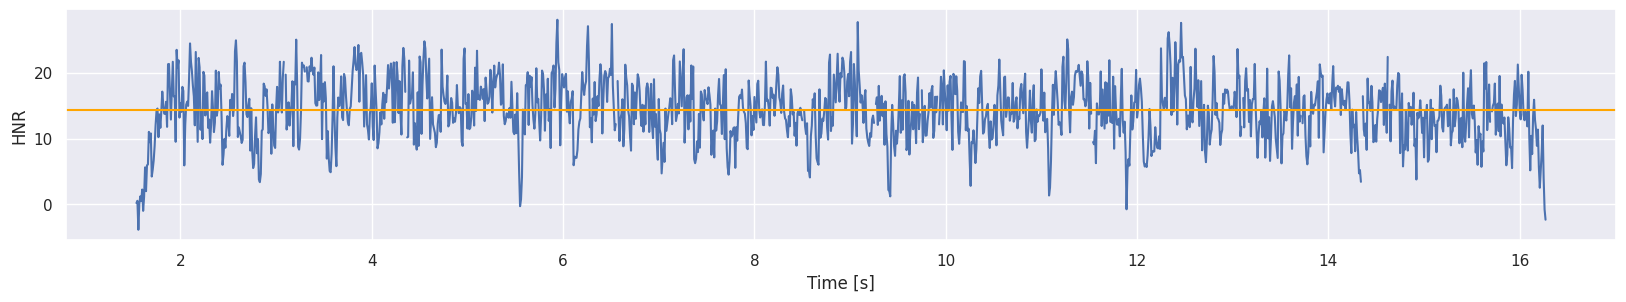

In [12]:
plt.plot(voiced_xs, hnr)
plt.xlabel("Time [s]")
plt.ylabel("HNR")
plt.axhline(y = hnr.nanmean(), color="orange")
print("Average HNR: {0:.2f}".format(hnr.nanmean().numpy()))

In [13]:
# Of course this can all be done in one step
f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio.squeeze(), sample_rate=sample_rate)

## PRAAT-Parselmouth

We'll run a similar analysis to verify that our numbers look accurate.

In [14]:
import parselmouth
import numpy as np

sound = parselmouth.Sound("qpn_PD00020_a1.wav")

In [15]:
pitch = sound.to_pitch()
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values==0] = np.nan
np.nanmean(pitch_values)

122.67467156291232

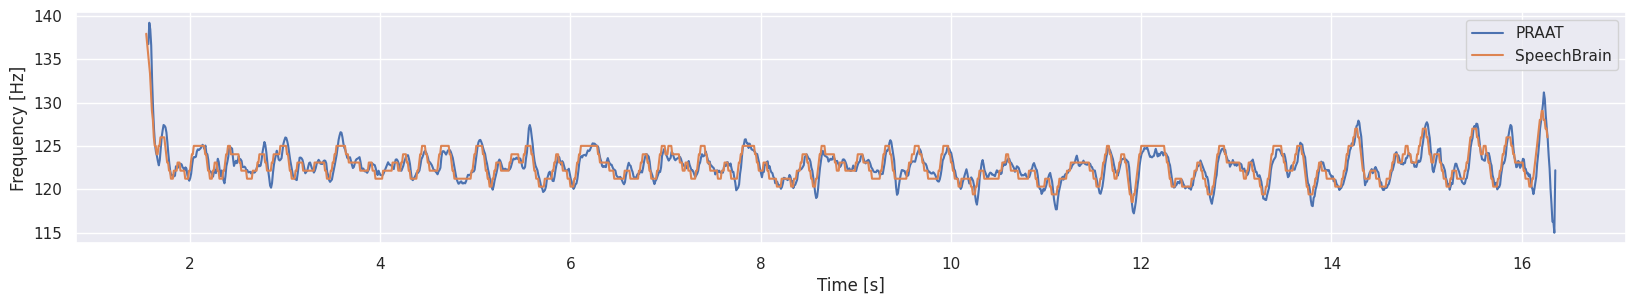

In [16]:
# Vs 122.75 -- pretty close.
plt.plot(pitch.xs(), pitch_values)
plt.plot(voiced_xs, estimated_f0)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

In [17]:
from parselmouth.praat import call
f0min = 75
f0max = 300
pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)

In [18]:
# 0.46% vs 0.49% is not too far off
localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter.nanmean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * localJitter))

Average Jitter (SpeechBrain): 0.49%
Average Jitter (PRAAT): 0.46%


In [19]:
# Hmm, maybe something to look at here...
localShimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer.nanmean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * localShimmer))

Average Shimmer (SpeechBrain): 3.50%
Average Shimmer (PRAAT): 2.74%


Average HNR (SpeechBrain): 14.3%
Average HNR (PRAAT): 19.3%


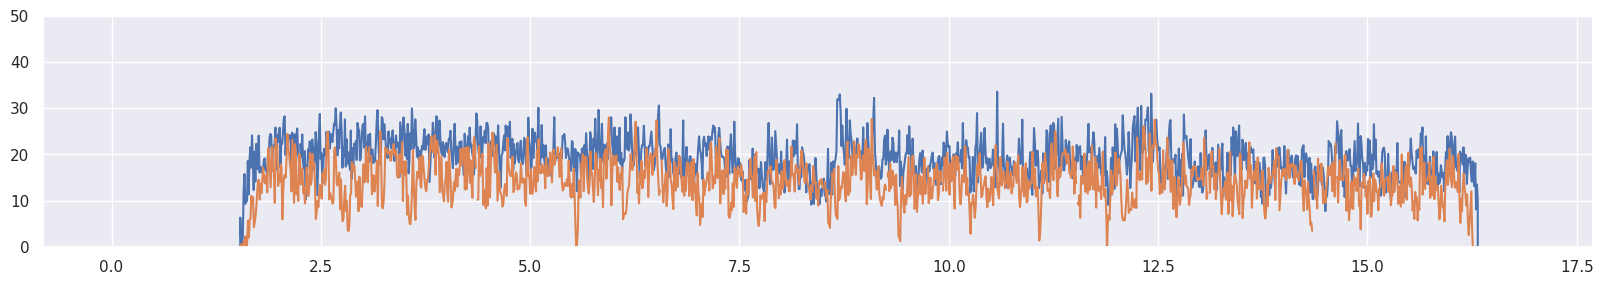

In [20]:
# HNR, again maybe not perfect, but close?
harmonicity = sound.to_harmonicity()
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T)
plt.plot(voiced_xs, hnr)
plt.ylim((0, 50))
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr.nanmean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))